# Benchmark similarity checks

Remember to compile `cnnclustering` with `TRACE_CYTHON=0` if timings should be measured. `TRACE_CYTHON=1` is required for line profiling and test coverage and will cause substantial overhead.

Notebook to organise benchmarks of different implementations of the density-criterion (similarity) check. In general, two neighbourhood containers are tested to have at least a certain number of common elements.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pre-requirements" data-toc-modified-id="Pre-requirements-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pre-requirements</a></span></li><li><span><a href="#Version-info" data-toc-modified-id="Version-info-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Version info</a></span></li><li><span><a href="#Helper-function-definitions" data-toc-modified-id="Helper-function-definitions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Helper function definitions</a></span></li><li><span><a href="#Runs" data-toc-modified-id="Runs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Runs</a></span><ul class="toc-item"><li><span><a href="#CommonNN-similarity-check" data-toc-modified-id="CommonNN-similarity-check-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>CommonNN similarity check</a></span><ul class="toc-item"><li><span><a href="#Run-a-a" data-toc-modified-id="Run-a-a-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Run a a</a></span></li><li><span><a href="#Run-a-b" data-toc-modified-id="Run-a-b-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Run a b</a></span></li><li><span><a href="#Run-a-c" data-toc-modified-id="Run-a-c-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>Run a c</a></span></li><li><span><a href="#Run-b-a" data-toc-modified-id="Run-b-a-4.1.4"><span class="toc-item-num">4.1.4&nbsp;&nbsp;</span>Run b a</a></span></li><li><span><a href="#Run-b-b" data-toc-modified-id="Run-b-b-4.1.5"><span class="toc-item-num">4.1.5&nbsp;&nbsp;</span>Run b b</a></span></li><li><span><a href="#Run-b-c" data-toc-modified-id="Run-b-c-4.1.6"><span class="toc-item-num">4.1.6&nbsp;&nbsp;</span>Run b c</a></span></li><li><span><a href="#Run-c-a" data-toc-modified-id="Run-c-a-4.1.7"><span class="toc-item-num">4.1.7&nbsp;&nbsp;</span>Run c a</a></span></li><li><span><a href="#Run-c-b" data-toc-modified-id="Run-c-b-4.1.8"><span class="toc-item-num">4.1.8&nbsp;&nbsp;</span>Run c b</a></span></li></ul></li><li><span><a href="#Scaling" data-toc-modified-id="Scaling-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Scaling</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Plots</a></span></li></ul></li></ul></div>

## Pre-requirements

In [1]:
from datetime import datetime

import cnnclustering
from cnnclustering import cluster
from cnnclustering import _fit, _primitive_types, _types
from IPython.core.magics.execution import TimeitResult
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm

import helper

In [2]:
mpl.rcParams["figure.dpi"] = 300

## Version info

In [3]:
print(f"{'Python':>20} :  ", *sys.version.splitlines())

modules = [
]

for alias, m in modules:
    try:
        print(f"{alias:>20} :  ", m.__version__)
    except AttributeError:
        print(f"{alias:>20} :  ", "no version info")

              Python :   3.8.8 (default, Mar 11 2021, 08:58:19)  [GCC 8.3.0]


In [4]:
print(f"cnnclustering :  ", cnnclustering.__version__)

cnnclustering :   0.4.2


## Helper function definitions

In [5]:
rng = np.random.default_rng(2021)

In [6]:
# Case generation
def gen_range(start, stop, step):
    yield from range(start, stop, step)
    
def gen_shuffled(start, stop, step):
    from_range = np.arange(start, stop, step)
    yield from rng.choice(from_range, size=((stop - start) // step), replace=False)

In [7]:
member_counts = [200 * 5**x for x in range(6)]
member_counts

[200, 1000, 5000, 25000, 125000, 625000]

In [8]:
CASES_MAP = {}

case_name = "equal_c50"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_range, (0, count, 1), gen_range, (0, count, 1), count // 2)
        )
    
case_name = "mixed_c50"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_shuffled, (0, count, 1), gen_shuffled, (0, count, 2), count // 4)
        )
    
case_name = "shuffled_c50"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_shuffled, (0, count, 1), gen_shuffled, (0, count, 1), count // 2)
        )
    
case_name = "mixed_shuffled_c50"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_shuffled, (0, count, 1), gen_shuffled, (0, count, 2), count // 4)
        )
    
case_name = "equal_c33"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_range, (0, count, 1), gen_range, (0, count, 1), count // 3)
        )

case_name = "mixed_c33"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_shuffled, (0, count, 1), gen_shuffled, (0, count, 2), count // 6)
        )

case_name = "shuffled_c33"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_shuffled, (0, count, 1), gen_shuffled, (0, count, 1), count // 3)
        )
    
case_name = "mixed_shuffled_c33"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_shuffled, (0, count, 1), gen_shuffled, (0, count, 2), count // 6)
        )
    
case_name = "no_check"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_range, (0, count, 1), gen_range, (0, count, 1), 0)
        )
    
case_name = "diff"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_range, (0, count, 1), gen_range, (count, 2*count, 1), 1)
        )
    
case_name = "equal_p625000"
CASES_MAP[case_name] = []
for count in member_counts:
    CASES_MAP[case_name].append(
        (str(count), gen_range, (0, 625000, 1), gen_range, (0, 625000, 1), count)
        )

In [9]:
CASES_MAP

{'equal_c50': [('200',
   <function __main__.gen_range(start, stop, step)>,
   (0, 200, 1),
   <function __main__.gen_range(start, stop, step)>,
   (0, 200, 1),
   100),
  ('1000',
   <function __main__.gen_range(start, stop, step)>,
   (0, 1000, 1),
   <function __main__.gen_range(start, stop, step)>,
   (0, 1000, 1),
   500),
  ('5000',
   <function __main__.gen_range(start, stop, step)>,
   (0, 5000, 1),
   <function __main__.gen_range(start, stop, step)>,
   (0, 5000, 1),
   2500),
  ('25000',
   <function __main__.gen_range(start, stop, step)>,
   (0, 25000, 1),
   <function __main__.gen_range(start, stop, step)>,
   (0, 25000, 1),
   12500),
  ('125000',
   <function __main__.gen_range(start, stop, step)>,
   (0, 125000, 1),
   <function __main__.gen_range(start, stop, step)>,
   (0, 125000, 1),
   62500),
  ('625000',
   <function __main__.gen_range(start, stop, step)>,
   (0, 625000, 1),
   <function __main__.gen_range(start, stop, step)>,
   (0, 625000, 1),
   312500)],
 'mixe

In [17]:
# Do not use
CASES_MAP = {
    "equal": [ # label, a, args_a, b, args_b c
        ("200", gen_range, (0, 200, 1), gen_range, (0, 200, 1), 5),
        ("1000", gen_range, (0, 1000, 1), gen_range, (0, 1000, 1), 50),
        ("5000", gen_range, (0, 5000, 1), gen_range, (0, 1000, 1), 500),
        ("25000", gen_range, (0, 10000, 1), gen_range, (0, 10000, 1), 5000),
        ("125000", gen_range, (0, 100000, 1), gen_range, (0, 100000, 1), 50000),
        ("625000", gen_range, (0, 100000, 1), gen_range, (0, 100000, 1), 50000),
    ],
    "mixed": [ # label, a, args_a, b, args_b c
        ("10", gen_range, (9, -1, -1), gen_range, (0, 5, 1), 5),
        ("100", gen_range, (99, -1, -1), gen_range, (0, 50, 1), 50),
        ("1000", gen_range, (999, -1, -1), gen_range, (0, 500, 1), 500),
        ("10000", gen_range, (9999, -1, -1), gen_range, (0, 5000, 1), 5000),
        ("100000", gen_range, (99999, -1, -1), gen_range, (0, 50000, 1), 50000),
        # ("1000000", gen_range, (999999, -1, 1), gen_range, (0, 500000), 500000),
    ],
    "shuffled": [ # label, a, args_a, b, args_b c
        ("10", gen_shuffled, (0, 10, 1), gen_shuffled, (0, 10, 1), 5),
        ("100", gen_shuffled, (0, 100, 1), gen_shuffled, (0, 100, 1), 50),
        ("1000", gen_shuffled, (0, 1000, 1), gen_shuffled, (0, 1000, 1), 500),
        ("10000", gen_shuffled, (0, 10000, 1), gen_shuffled, (0, 10000, 1), 5000),
        ("100000", gen_shuffled, (0, 100000, 1), gen_shuffled, (0, 100000, 1), 50000),
        # ("1000000", gen_shuffled, (0, 1000000, 1), gen_shuffled, (0, 1000000, 1), 500000),
    ],
    "mixed_shuffled": [ # label, a, args_a, b, args_b c
        ("10", gen_shuffled, (0, 10, 1), gen_shuffled, (0, 5, 1), 5),
        ("100", gen_shuffled, (0, 100, 1), gen_shuffled, (0, 50, 1), 50),
        ("1000", gen_shuffled, (0, 1000, 1), gen_shuffled, (0, 500, 1), 500),
        ("10000", gen_shuffled, (0, 10000, 1), gen_shuffled, (0, 5000, 1), 5000),
        ("100000", gen_shuffled, (0, 100000, 1), gen_shuffled, (0, 50000, 1), 50000),
        # ("1000000", gen_shuffled, (0, 1000000, 1), gen_shuffled, (0, 1000000, 1), 500000),
    ],
    "mixed_shuffled_break_early": [ # label, a, args_a, b, args_b c
        ("10", gen_shuffled, (0, 10, 1), gen_shuffled, (0, 5, 1), 3),
        ("100", gen_shuffled, (0, 100, 1), gen_shuffled, (0, 50, 1), 30),
        ("1000", gen_shuffled, (0, 1000, 1), gen_shuffled, (0, 500, 1), 300),
        ("10000", gen_shuffled, (0, 10000, 1), gen_shuffled, (0, 5000, 1), 3000),
        ("100000", gen_shuffled, (0, 100000, 1), gen_shuffled, (0, 50000, 1), 30000),
        # ("1000000", gen_shuffled, (0, 1000000, 1), gen_shuffled, (0, 1000000, 1), 500000),
    ],
    "no_check": [ # label, a, args_a, b, args_b c
        ("10", gen_range, (0, 10, 1), gen_range, (0, 10, 1), 0),
        ("100", gen_range, (0, 100, 1), gen_range, (0, 100, 1), 0),
        ("1000", gen_range, (0, 1000, 1), gen_range, (0, 1000, 1), 0),
        ("10000", gen_range, (0, 10000, 1), gen_range, (0, 10000, 1), 0),
        ("100000", gen_range, (0, 100000, 1), gen_range, (0, 100000, 1), 0),
        # ("1000000", gen_range, (0, 1000000, 1), gen_range, (0, 1000000, 1), 2000000),
    ],
    "equal_break_early": [ # label, a, args_a, b, args_b c
        ("10", gen_range, (0, 10, 1), gen_range, (0, 10, 1), 3),
        ("100", gen_range, (0, 100, 1), gen_range, (0, 100, 1), 30),
        ("1000", gen_range, (0, 1000, 1), gen_range, (0, 1000, 1), 300),
        ("10000", gen_range, (0, 10000, 1), gen_range, (0, 10000, 1), 3000),
        ("100000", gen_range, (0, 100000, 1), gen_range, (0, 100000, 1), 30000),
        # ("1000000", gen_range, (0, 1000000), gen_range, (0, 1000000), 300000),
    ],
    "shuffled_break_early":[ # label, a, args_a, b, args_b c
        ("10", gen_shuffled, (0, 10, 1), gen_shuffled, (0, 10, 1), 3),
        ("100", gen_shuffled, (0, 100, 1), gen_shuffled, (0, 100, 1), 30),
        ("1000", gen_shuffled, (0, 1000, 1), gen_shuffled, (0, 1000, 1), 300),
        ("10000", gen_shuffled, (0, 10000, 1), gen_shuffled, (0, 10000, 1), 3000),
        ("100000", gen_shuffled, (0, 100000, 1), gen_shuffled, (0, 100000, 1), 30000),
        # ("1000000", gen_range, (0, 1000000), gen_range, (0, 1000000), 300000),
    ],
    "diff": [ # label, a, args_a, b, args_b c
        ("10", gen_range, (0, 10, 1), gen_range, (10, 20, 1), 10),
        ("100", gen_range, (0, 100, 1), gen_range, (100, 200, 1), 10),
        ("1000", gen_range, (0, 1000, 1), gen_range, (1000, 2000, 1), 10),
        ("10000", gen_range, (0, 10000, 1), gen_range, (10000, 20000, 1), 10),
        ("100000", gen_range, (0, 100000, 1), gen_range, (100000, 200000, 1), 10),
        # ("1000000", gen_range, (0, 1000000), gen_range, (1000000, 2000000), 10),
    ],
    "equal_c": [ # label, a, args_a, b, args_b c
        ("10", gen_range, (0, 100000, 1), gen_range, (0, 100000, 1), 10),
        ("100", gen_range, (0, 100000, 1), gen_range, (0, 100000, 1), 100),
        ("1000", gen_range, (0, 100000, 1), gen_range, (0, 100000, 1), 1000),
        ("10000", gen_range, (0, 100000, 1), gen_range, (0, 100000, 1), 10000),
        ("100000", gen_range, (0, 100000, 1), gen_range, (0, 100000, 1), 100000),
        # ("1000000", gen_range, (0, 1000000), gen_range, (1000000, 2000000), 10),
    ]
}

In [10]:
def collect_timings(
        checker, na, nb,
        cases, timings=None):
    """Orchestrate timings
    
    Args:
        
        
    Keyword args:
        timings: An optional timings mapping which results should be
            put into.
    
    Returns:
        timings mapping
    """
    
    # Timed function has to be in global namespace to be discovered by %timeit magic
    global timed_args
    global timed_kwargs
    global timed_func
    
    if timings is None:
        timings = {}
    
    progress = tqdm(cases, desc="Run completed")
    
    for run_index, (run_id, gen_a, args_a, gen_b, args_b, c) in enumerate(progress):
        
        na.reset()
        for index in gen_a(*args_a):
            na.assign(index)

        nb.reset()
        for index in gen_b(*args_b):
            nb.assign(index)
        
        cluster_params = _types.ClusterParameters(0, c)
        
        timings[run_id] = %timeit -q -o checker.check(na, nb, cluster_params)
        
        tqdm.write(f"Timed run ID: {run_id:>10}    ({datetime.now().strftime('%d.%m.%Y %H:%M:%S')})")
        
    return timings

## Runs

In [11]:
if "RUN_TIMINGS_MAP" not in dir():
    RUN_TIMINGS_MAP = {}

In [12]:
report_dir = pathlib.Path("reports/qcm07/cnnclustering_similarity_check")

In [64]:
case_list = CASES_MAP.keys()

run_list = [
    "run_a_a",
    "run_a_b",
    "run_a_c",
    "run_b_a",
    "run_c_a",
]

for run_name in run_list:
    for case_name in case_list:
        full_run_name = f"{case_name}_{run_name}"
        report_file = report_dir / f"{full_run_name}.json"
        try:
            RUN_TIMINGS_MAP[full_run_name] = helper.load_report(report_file)
        except FileNotFoundError:
            pass

### CommonNN similarity check

Checking of similarity criterion for fixed cases of neighbour lists:

  - SimilarityCheckerExtContains
    - NeighboursExtVector [run a_a](#run_a_a)
    - NeighboursExtCPPUnorderedSet [run a_b](#run_a_b)
    - NeighboursExtVectorCPPUnorderedSet [run a_c](#run_a_c)
  - SimilarityCheckerExtSwitchContains
    - NeighboursExtVector [run b_a](#run_b_a)
    - NeighboursExtCPPUnorderedSet [run b_b](#run_b_b)
    - NeighboursExtVectorCPPUnorderedSet [run b_c](#run_b_c)
  - SimilarityCheckerExtScreensorted
    - NeighboursExtVector [run c_a](#run_c_a)
    - NeighboursExtVectorCPPUnorderedSet [run c_b](#run_c_b)

<a id="run_a_a"></a>
#### Run a a

In [17]:
case_list = CASES_MAP.keys()
case_list

dict_keys(['equal_c50', 'mixed_c50', 'shuffled_c50', 'mixed_shuffled_c50', 'equal_c33', 'mixed_c33', 'shuffled_c33', 'mixed_shuffled_c33', 'no_check', 'diff', 'equal_p625000'])

In [18]:
case_list = [
    # 'equal_c50',
    # 'mixed_c50',
    # 'shuffled_c50',
    # 'mixed_shuffled_c50',
    # 'equal_c33',
    # 'mixed_c33',
    # 'shuffled_c33',
    # 'mixed_shuffled_c33',
    # 'no_check',
    'diff',
    'equal_p625000'
]

In [19]:
checker = _types.SimilarityCheckerExtContains()
na = _types.NeighboursExtVector(1)
nb = _types.NeighboursExtVector(1)

In [ ]:
run_name = "run_a_a"
for case_name in case_list:
    full_run_name = f"{case_name}_{run_name}"
    report_file = report_dir / f"{full_run_name}.json"
    
    print(f"Collection for run: {full_run_name}")
    RUN_TIMINGS_MAP[full_run_name] = {}
    collect_timings(
        checker,
        na,
        nb,
        CASES_MAP[case_name],
        timings=RUN_TIMINGS_MAP[full_run_name]
    )
    
    helper.save_report(RUN_TIMINGS_MAP[full_run_name], report_file, overwrite=True)
    
    helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[full_run_name]))
    
    print()

Collection for run: diff_run_a_a


Run completed:   0%|          | 0/6 [00:00<?, ?it/s]

Timed run ID:        200    (18.06.2021 21:56:20)
Timed run ID:       1000    (18.06.2021 21:56:22)


<a id="run_a_b"></a>
#### Run a b

In [ ]:
case_list = [
    'equal_c50',
    'mixed_c50',
    'shuffled_c50',
    'mixed_shuffled_c50',
    'equal_c33',
    'mixed_c33',
    'shuffled_c33',
    'mixed_shuffled_c33',
    'no_check',
    'diff',
    'equal_p625000'
]

In [ ]:
checker = _types.SimilarityCheckerExtContains()
na = _types.NeighboursExtCPPUnorderedSet()
nb = _types.NeighboursExtCPPUnorderedSet()

In [ ]:
run_name = "run_a_b"
for case_name in case_list:
    full_run_name = f"{case_name}_{run_name}"
    report_file = report_dir / f"{full_run_name}.json"
    
    print(f"Collection for run: {full_run_name}")
    RUN_TIMINGS_MAP[full_run_name] = {}
    collect_timings(
        checker,
        na,
        nb,
        CASES_MAP[case_name],
        timings=RUN_TIMINGS_MAP[full_run_name]
    )
    
    helper.save_report(RUN_TIMINGS_MAP[full_run_name], report_file, overwrite=True)
    
    helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[full_run_name]))
    
    print()

<a id="run_a_c"></a>
#### Run a c

In [ ]:
case_list = [
    'equal_c50',
    'mixed_c50',
    'shuffled_c50',
    'mixed_shuffled_c50',
    'equal_c33',
    'mixed_c33',
    'shuffled_c33',
    'mixed_shuffled_c33',
    'no_check',
    'diff',
    'equal_p625000'
]

In [ ]:
checker = _types.SimilarityCheckerExtContains()
na = _types.NeighboursExtVectorCPPUnorderedSet(1)
nb = _types.NeighboursExtVectorCPPUnorderedSet(1)

In [ ]:
run_name = "run_a_c"
for case_name in case_list:
    full_run_name = f"{case_name}_{run_name}"
    report_file = report_dir / f"{full_run_name}.json"
    
    print(f"Collection for run: {full_run_name}")
    RUN_TIMINGS_MAP[full_run_name] = {}
    collect_timings(
        checker,
        na,
        nb,
        CASES_MAP[case_name],
        timings=RUN_TIMINGS_MAP[full_run_name]
    )
    
    helper.save_report(RUN_TIMINGS_MAP[full_run_name], report_file, overwrite=True)
    
    helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[full_run_name]))
    
    print()

<a id="run_b_a"></a>
#### Run b a

In [ ]:
case_list = [
    'equal_c50',
    'mixed_c50',
    'shuffled_c50',
    'mixed_shuffled_c50',
    'equal_c33',
    'mixed_c33',
    'shuffled_c33',
    'mixed_shuffled_c33',
    'no_check',
    'diff',
    'equal_p625000'
]

In [ ]:
checker = _types.SimilarityCheckerExtSwitchContains()
na = _types.NeighboursExtVector(1)
nb = _types.NeighboursExtVector(1)

In [ ]:
run_name = "run_b_a"
for case_name in case_list:
    full_run_name = f"{case_name}_{run_name}"
    report_file = report_dir / f"{full_run_name}.json"
    
    print(f"Collection for run: {full_run_name}")
    RUN_TIMINGS_MAP[full_run_name] = {}
    collect_timings(
        checker,
        na,
        nb,
        CASES_MAP[case_name],
        timings=RUN_TIMINGS_MAP[full_run_name]
    )
    
    helper.save_report(RUN_TIMINGS_MAP[full_run_name], report_file, overwrite=True)
    
    helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[full_run_name]))
    
    print()

<a id="run_b_b"></a>
#### Run b b

In [ ]:
case_list = [
    'equal_c50',
    'mixed_c50',
    'shuffled_c50',
    'mixed_shuffled_c50',
    'equal_c33',
    'mixed_c33',
    'shuffled_c33',
    'mixed_shuffled_c33',
    'no_check',
    'diff',
    'equal_p625000'
]

In [ ]:
checker = _types.SimilarityCheckerExtSwitchContains()
na = _types.NeighboursExtCPPUnorderedSet()
nb = _types.NeighboursExtCPPUnorderedSet()

In [ ]:
run_name = "run_b_b"
for case_name in case_list:
    full_run_name = f"{case_name}_{run_name}"
    report_file = report_dir / f"{full_run_name}.json"
    
    print(f"Collection for run: {full_run_name}")
    RUN_TIMINGS_MAP[full_run_name] = {}
    collect_timings(
        checker,
        na,
        nb,
        CASES_MAP[case_name],
        timings=RUN_TIMINGS_MAP[full_run_name]
    )
    
    helper.save_report(RUN_TIMINGS_MAP[full_run_name], report_file, overwrite=True)
    
    helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[full_run_name]))
    
    print()

<a id="run_b_c"></a>
#### Run b c

In [ ]:
case_list = [
    'equal_c50',
    'mixed_c50',
    'shuffled_c50',
    'mixed_shuffled_c50',
    'equal_c33',
    'mixed_c33',
    'shuffled_c33',
    'mixed_shuffled_c33',
    'no_check',
    'diff',
    'equal_p625000'
]

In [ ]:
checker = _types.SimilarityCheckerExtSwitchContains()
na = _types.NeighboursExtVectorCPPUnorderedSet(1)
nb = _types.NeighboursExtVectorCPPUnorderedSet(1)

In [ ]:
run_name = "run_b_c"
for case_name in case_list:
    full_run_name = f"{case_name}_{run_name}"
    report_file = report_dir / f"{full_run_name}.json"
    
    print(f"Collection for run: {full_run_name}")
    RUN_TIMINGS_MAP[full_run_name] = {}
    collect_timings(
        checker,
        na,
        nb,
        CASES_MAP[case_name],
        timings=RUN_TIMINGS_MAP[full_run_name]
    )
    
    helper.save_report(RUN_TIMINGS_MAP[full_run_name], report_file, overwrite=True)
    
    helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[full_run_name]))
    
    print()

<a id="run_c_a"></a>
#### Run c a

In [ ]:
case_list = [
    'equal_c50',
    'mixed_c50',
    'equal_c33',
    'mixed_c33',
    'no_check',
    'diff',
    'equal_p625000'
]

In [ ]:
checker = _types.SimilarityCheckerExtScreensorted()
na = _types.NeighboursExtVector(1)
nb = _types.NeighboursExtVector(1)

In [ ]:
run_name = "run_c_a"
for case_name in case_list:
    full_run_name = f"{case_name}_{run_name}"
    report_file = report_dir / f"{full_run_name}.json"
    
    print(f"Collection for run: {full_run_name}")
    RUN_TIMINGS_MAP[full_run_name] = {}
    collect_timings(
        checker,
        na,
        nb,
        CASES_MAP[case_name],
        timings=RUN_TIMINGS_MAP[full_run_name]
    )
    
    helper.save_report(RUN_TIMINGS_MAP[full_run_name], report_file, overwrite=True)
    
    helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[full_run_name]))
    
    print()

<a id="run_c_b"></a>
#### Run c b

In [ ]:
case_list = [
    'equal_c50',
    'mixed_c50',
    'equal_c33',
    'mixed_c33',
    'no_check',
    'diff',
    'equal_p625000'
]

In [ ]:
checker = _types.SimilarityCheckerExtScreensorted()
na = _types.NeighboursExtVectorCPPUnorderedSet(1)
nb = _types.NeighboursExtVectorCPPUnorderedSet(1)

In [ ]:
run_name = "run_c_b"
for case_name in case_list:
    full_run_name = f"{case_name}_{run_name}"
    report_file = report_dir / f"{full_run_name}.json"
    
    print(f"Collection for run: {full_run_name}")
    RUN_TIMINGS_MAP[full_run_name] = {}
    collect_timings(
        checker,
        na,
        nb,
        CASES_MAP[case_name],
        timings=RUN_TIMINGS_MAP[full_run_name]
    )
    
    helper.save_report(RUN_TIMINGS_MAP[full_run_name], report_file, overwrite=True)
    
    helper.print_ratios(helper.get_ratios(RUN_TIMINGS_MAP[full_run_name]))
    
    print()

In [ ]:
RUN_TIMINGS_MAP.keys()

### Scaling

Fit for empirical growth function:

$ t = a n^b + c$

In [ ]:
def scale(x, y, newx):
    def growth(n, a, b):
        return a * n**b + c
    
    try:
        popt, pcov = curve_fit(growth, x, y, p0=(0, 2, 0))
        perr = np.sqrt(np.diag(pcov))
    except RuntimeError as error:
        print(error)
    else:
        return growth(newx, *popt), (popt[1], perr[1])

In [ ]:
if "RUN_SCALING_MAP" not in dir():
    RUN_SCALING_MAP = {}

In [ ]:
for full_run_name, timings in RUN_TIMINGS_MAP.items():
    print(full_run_name)
    x, y = zip(*((int(k), v.average) for k, v in timings.items()))
    x = np.asarray(x)
    y = np.asarray(y)
    sorti = np.argsort(x)
    x = x[sorti]
    y = y[sorti]
    x = x[0:]
    y = y[0:]
    
    newx = np.linspace(x[0], x[-1], 50)
    RUN_SCALING_MAP[full_run_name] = scale(x, y, newx), newx

### Plots

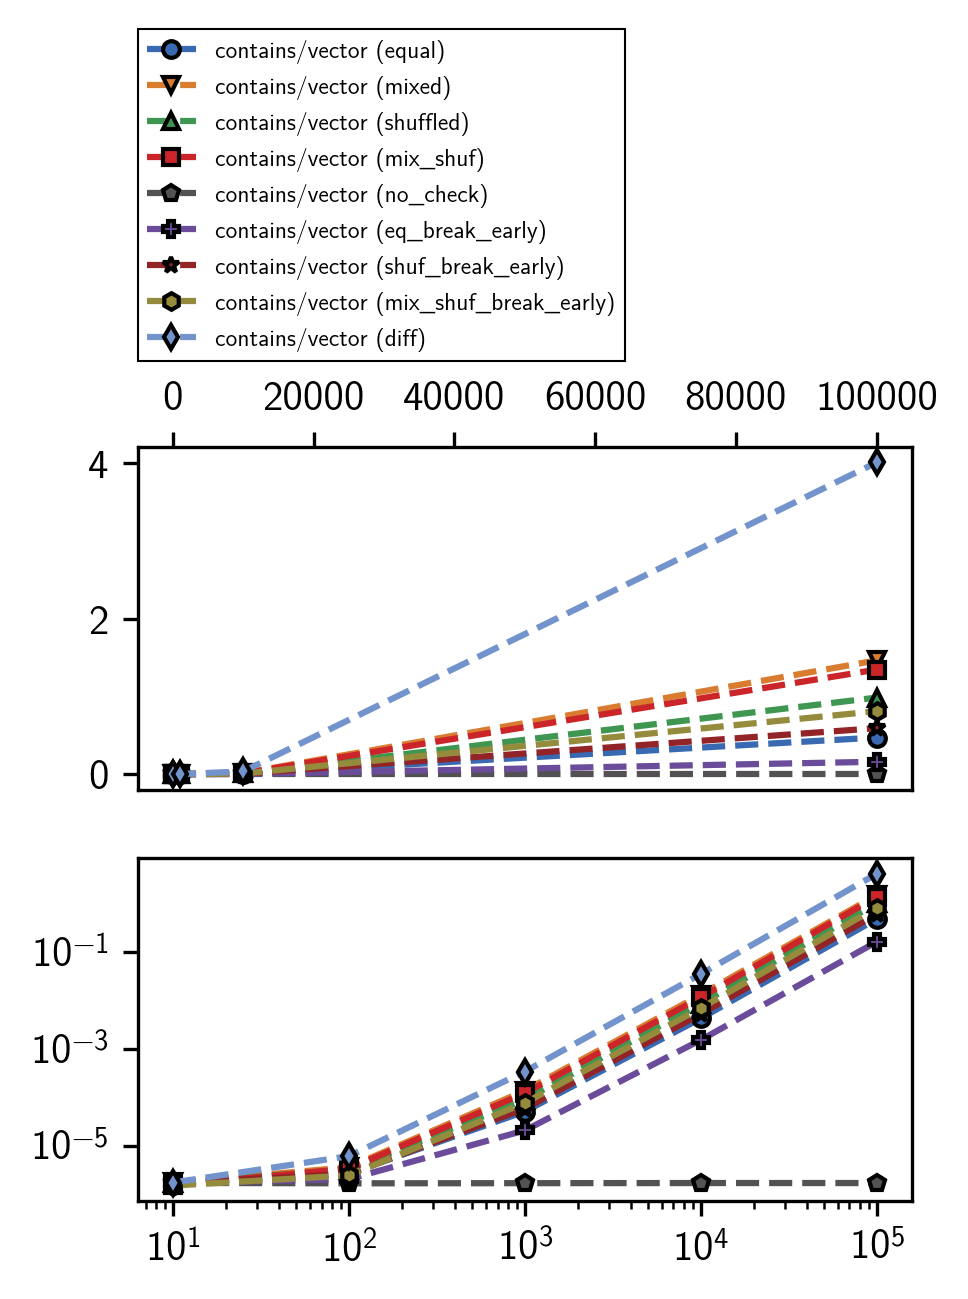

In [104]:
fig, (normal_ax, log_ax) = plt.subplots(2, 1, figsize=(3.33, 3.33))

run_name_list = [
    ('equal_run_a_a', 'contains/vector (equal)'),
    ('mixed_run_a_a', 'contains/vector (mixed)'),
    ('shuffled_run_a_a', 'contains/vector (shuffled)'),
    ('mixed_shuffled_run_a_a', 'contains/vector (mix_shuf)'),
    ('no_check_run_a_a', 'contains/vector (no_check)'),
    ('equal_break_early_run_a_a', 'contains/vector (eq_break_early)'),
    ('shuffled_break_early_run_a_a', 'contains/vector (shuf_break_early)'),
    ('mixed_shuffled_break_early_run_a_a', 'contains/vector (mix_shuf_break_early)'),
    ('diff_run_a_a', 'contains/vector (diff)'),
]
markers = iter(["o", "v", "^", "s", "p", "P", "*", "h", "d"])

for name, label in run_name_list:
    marker = next(markers)
    
    helper.plot_timings(
        RUN_TIMINGS_MAP[name],
        ax=normal_ax,
        id_to_x=lambda x: int(x),
        sort_ids=True,
        set_ax_props=False,
        plot_props={
            "label": label,
            "marker": marker,
            "markersize": 4
        }
    )
    
    line = normal_ax.lines[-1]
    log_line, = log_ax.plot(*line.get_xydata().T)
    saved_transform = log_line.get_transform()
    saved_clipbox = log_line.clipbox
    log_line.update_from(line)
    log_line.set_transform(saved_transform)
    log_line.clipbox = saved_clipbox
    
normal_ax.xaxis.tick_top()

normal_ax.set(**{
    "xlabel": None,
    "xlabel": None
})

log_ax.set(**{
    "xlabel": None,
    "xlabel": None,
    "xscale": "log",
    "yscale": "log",
})

legend = normal_ax.legend(
    fancybox=False,
    framealpha=1,
    edgecolor="k",
    fontsize="xx-small",
    loc=(0, 1.25)
    )
legend.get_frame().set_linewidth(0.5)

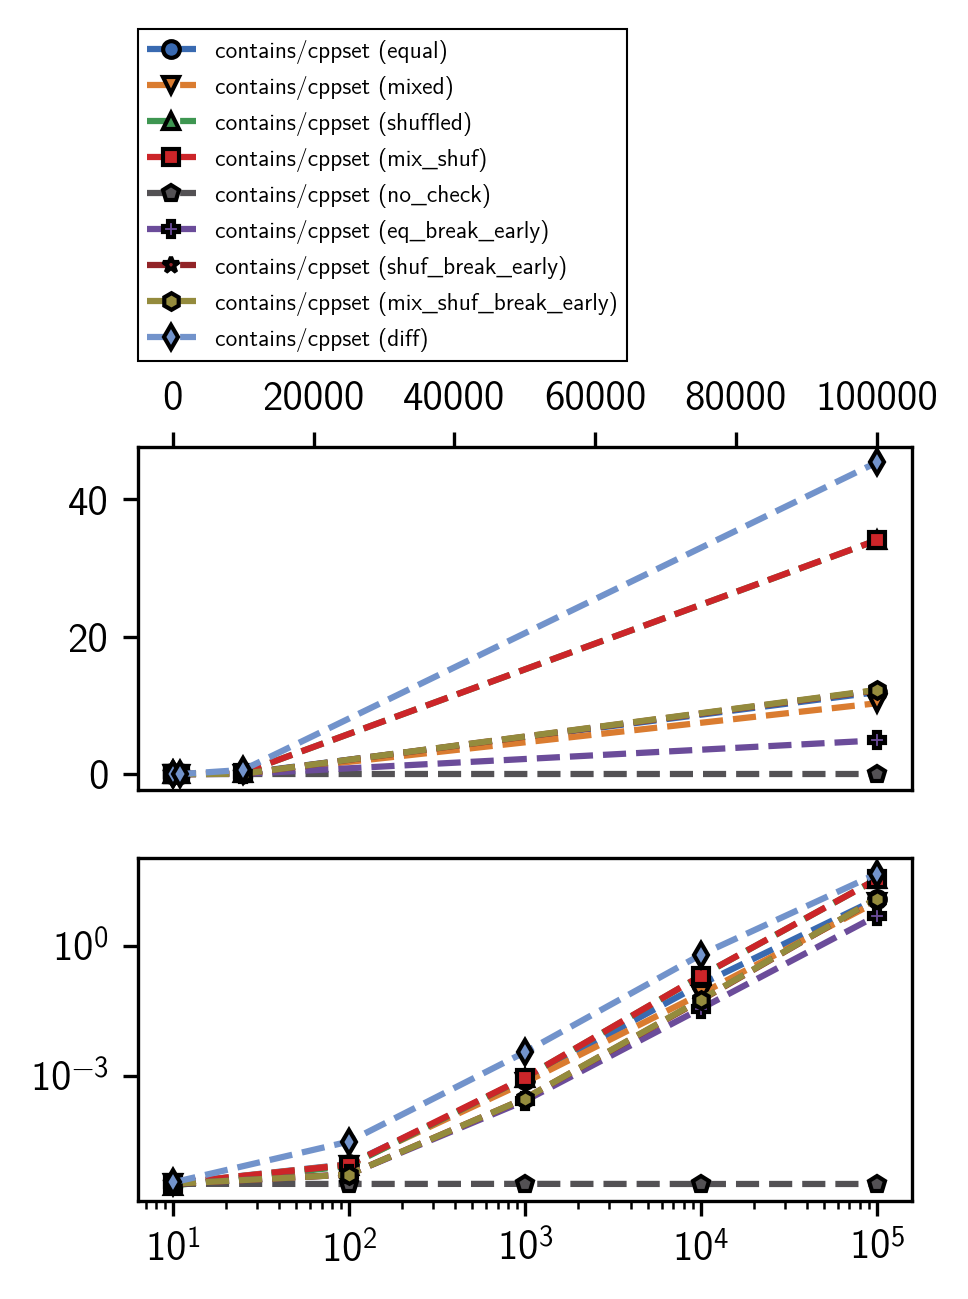

In [15]:
fig, (normal_ax, log_ax) = plt.subplots(2, 1, figsize=(3.33, 3.33))

run_name_list = [
    ('equal_run_a_b', 'contains/cppset (equal)'),
    ('mixed_run_a_b', 'contains/cppset (mixed)'),
    ('shuffled_run_a_b', 'contains/cppset (shuffled)'),
    ('mixed_shuffled_run_a_b', 'contains/cppset (mix_shuf)'),
    ('no_check_run_a_b', 'contains/cppset (no_check)'),
    ('equal_break_early_run_a_b', 'contains/cppset (eq_break_early)'),
    ('shuffled_break_early_run_a_b', 'contains/cppset (shuf_break_early)'),
    ('mixed_shuffled_break_early_run_a_b', 'contains/cppset (mix_shuf_break_early)'),
    ('diff_run_a_b', 'contains/cppset (diff)'),
]
markers = iter(["o", "v", "^", "s", "p", "P", "*", "h", "d"])

for name, label in run_name_list:
    marker = next(markers)
    
    helper.plot_timings(
        RUN_TIMINGS_MAP[name],
        ax=normal_ax,
        id_to_x=lambda x: int(x),
        sort_ids=True,
        set_ax_props=False,
        plot_props={
            "label": label,
            "marker": marker,
            "markersize": 4
        }
    )
    
    line = normal_ax.lines[-1]
    log_line, = log_ax.plot(*line.get_xydata().T)
    saved_transform = log_line.get_transform()
    saved_clipbox = log_line.clipbox
    log_line.update_from(line)
    log_line.set_transform(saved_transform)
    log_line.clipbox = saved_clipbox
    
normal_ax.xaxis.tick_top()

normal_ax.set(**{
    "xlabel": None,
    "xlabel": None
})

log_ax.set(**{
    "xlabel": None,
    "xlabel": None,
    "xscale": "log",
    "yscale": "log",
})

legend = normal_ax.legend(
    fancybox=False,
    framealpha=1,
    edgecolor="k",
    fontsize="xx-small",
    loc=(0, 1.25)
    )
legend.get_frame().set_linewidth(0.5)

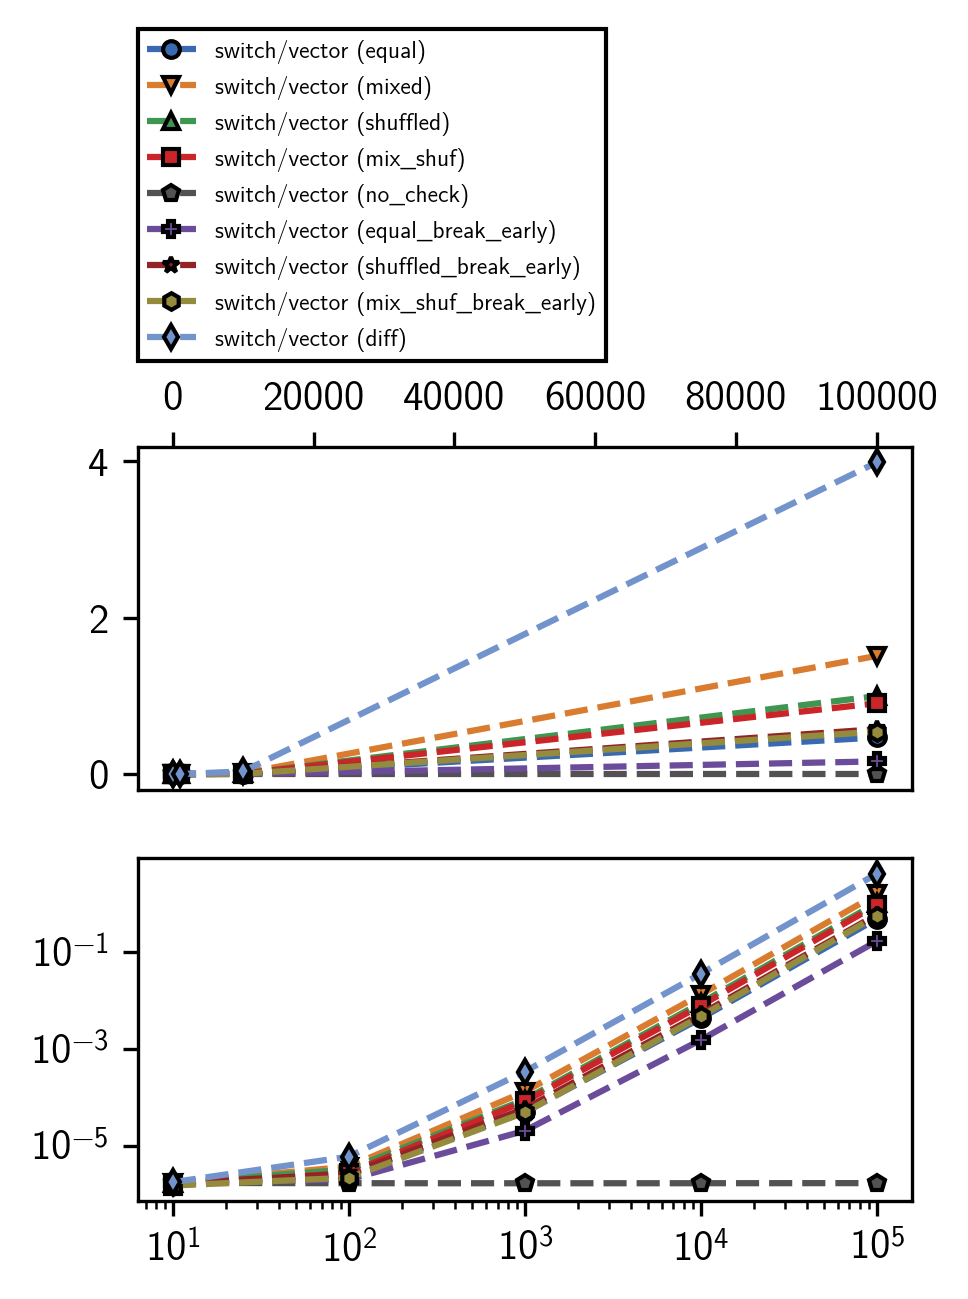

In [106]:
fig, (normal_ax, log_ax) = plt.subplots(2, 1, figsize=(3.33, 3.33))

run_name_list = [
    ('equal_run_b_a', 'switch/vector (equal)'),
    ('mixed_run_b_a', 'switch/vector (mixed)'),
    ('shuffled_run_b_a', 'switch/vector (shuffled)'),
    ('mixed_shuffled_run_b_a', 'switch/vector (mix_shuf)'),
    ('no_check_run_b_a', 'switch/vector (no_check)'),
    ('equal_break_early_run_b_a', 'switch/vector (equal_break_early)'),
    ('shuffled_break_early_run_b_a', 'switch/vector (shuffled_break_early)'),
    ('mixed_shuffled_break_early_run_b_a', 'switch/vector (mix_shuf_break_early)'),
    ('diff_run_b_a', 'switch/vector (diff)'),
]
markers = iter(["o", "v", "^", "s", "p", "P", "*", "h", "d"])

for name, label in run_name_list:
    marker = next(markers)
    
    helper.plot_timings(
        RUN_TIMINGS_MAP[name],
        ax=normal_ax,
        id_to_x=lambda x: int(x),
        sort_ids=True,
        set_ax_props=False,
        plot_props={
            "label": label,
            "marker": marker,
            "markersize": 4
        }
    )
    
    line = normal_ax.lines[-1]
    log_line, = log_ax.plot(*line.get_xydata().T)
    saved_transform = log_line.get_transform()
    saved_clipbox = log_line.clipbox
    log_line.update_from(line)
    log_line.set_transform(saved_transform)
    log_line.clipbox = saved_clipbox
    
normal_ax.xaxis.tick_top()

normal_ax.set(**{
    "xlabel": None,
    "xlabel": None
})

log_ax.set(**{
    "xlabel": None,
    "xlabel": None,
    "xscale": "log",
    "yscale": "log",
})

legend = normal_ax.legend(
    fancybox=False,
    framealpha=1,
    edgecolor="k",
    fontsize="xx-small",
    loc=(0, 1.25)
    )

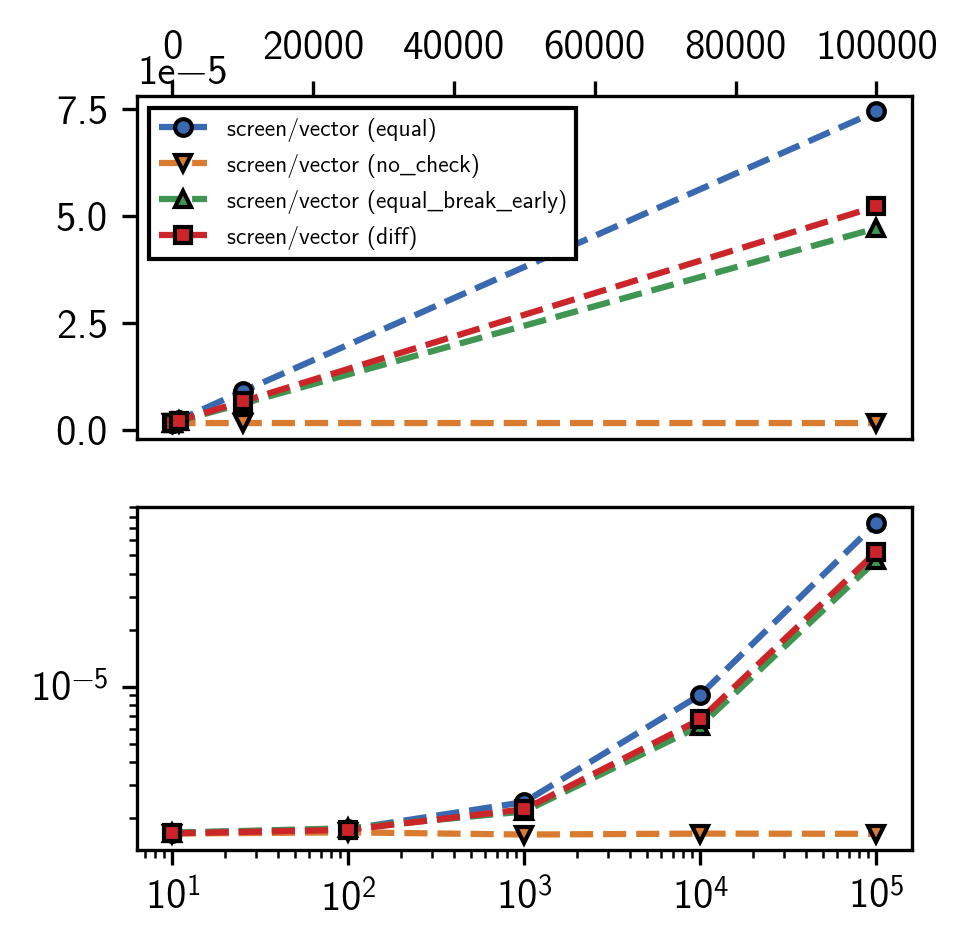

In [86]:
fig, (normal_ax, log_ax) = plt.subplots(2, 1, figsize=(3.33, 3.33))

run_name_list = [
    ('equal_run_c_a', 'screen/vector (equal)'),
    ('no_check_run_c_a', 'screen/vector (no_check)'),
    ('equal_break_early_run_c_a', 'screen/vector (equal_break_early)'),
    ('diff_run_c_a', 'screen/vector (diff)'),
]
markers = iter(["o", "v", "^", "s", "p", "P", "*", "h", "d"])

for name, label in run_name_list:
    marker = next(markers)
    
    helper.plot_timings(
        RUN_TIMINGS_MAP[name],
        ax=normal_ax,
        id_to_x=lambda x: int(x),
        sort_ids=True,
        set_ax_props=False,
        plot_props={
            "label": label,
            "marker": marker,
            "markersize": 4
        }
    )
    
    line = normal_ax.lines[-1]
    log_line, = log_ax.plot(*line.get_xydata().T)
    saved_transform = log_line.get_transform()
    saved_clipbox = log_line.clipbox
    log_line.update_from(line)
    log_line.set_transform(saved_transform)
    log_line.clipbox = saved_clipbox
    
normal_ax.xaxis.tick_top()

normal_ax.set(**{
    "xlabel": None,
    "xlabel": None
})

log_ax.set(**{
    "xlabel": None,
    "xlabel": None,
    "xscale": "log",
    "yscale": "log",
})

legend = normal_ax.legend(
    fancybox=False,
    framealpha=1,
    edgecolor="k",
    fontsize="xx-small",
    # loc=(0.8, 0.33)
    )

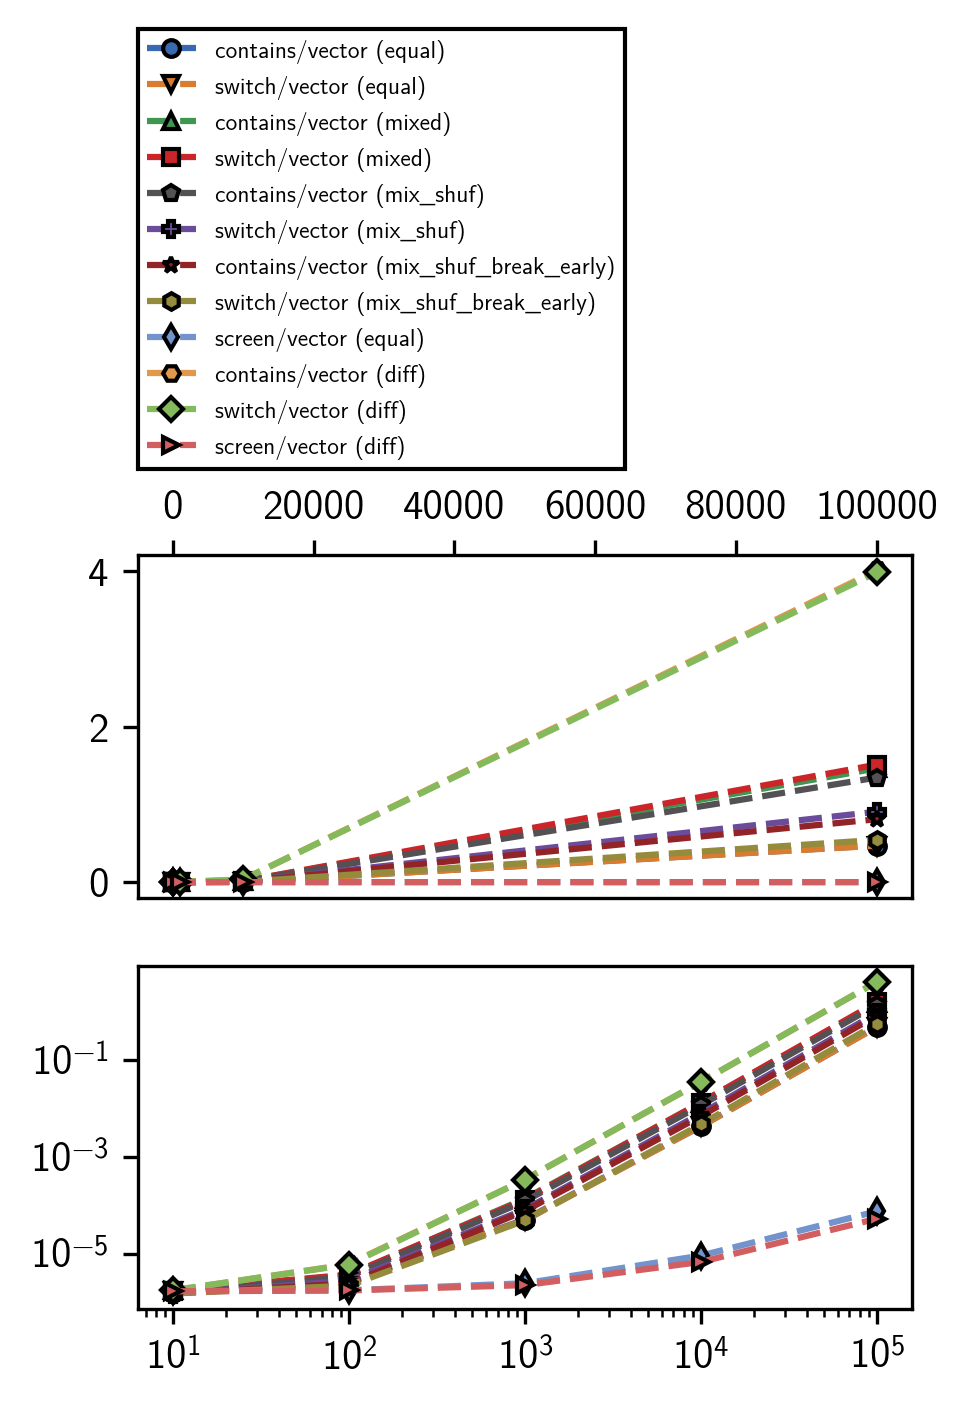

In [115]:
fig, (normal_ax, log_ax) = plt.subplots(2, 1, figsize=(3.33, 3.33))

run_name_list = [
    ('equal_run_a_a', 'contains/vector (equal)'),
    ('equal_run_b_a', 'switch/vector (equal)'),
    ('mixed_run_a_a', 'contains/vector (mixed)'),
    ('mixed_run_b_a', 'switch/vector (mixed)'),
    ('mixed_shuffled_run_a_a', 'contains/vector (mix_shuf)'),
    ('mixed_shuffled_run_b_a', 'switch/vector (mix_shuf)'),
    ('mixed_shuffled_break_early_run_a_a', 'contains/vector (mix_shuf_break_early)'),
    ('mixed_shuffled_break_early_run_b_a', 'switch/vector (mix_shuf_break_early)'),
    ('equal_run_c_a', 'screen/vector (equal)'),
    ('diff_run_a_a', 'contains/vector (diff)'),
    ('diff_run_b_a', 'switch/vector (diff)'),
    ('diff_run_c_a', 'screen/vector (diff)'),
]
markers = iter(["o", "v", "^", "s", "p", "P", "*", "h", "d", "H", "D", ">", "8"])

for name, label in run_name_list:
    marker = next(markers)
    
    helper.plot_timings(
        RUN_TIMINGS_MAP[name],
        ax=normal_ax,
        id_to_x=lambda x: int(x),
        sort_ids=True,
        set_ax_props=False,
        plot_props={
            "label": label,
            "marker": marker,
            "markersize": 4
        }
    )
    
    line = normal_ax.lines[-1]
    log_line, = log_ax.plot(*line.get_xydata().T)
    saved_transform = log_line.get_transform()
    saved_clipbox = log_line.clipbox
    log_line.update_from(line)
    log_line.set_transform(saved_transform)
    log_line.clipbox = saved_clipbox
    
normal_ax.xaxis.tick_top()

normal_ax.set(**{
    "xlabel": None,
    "xlabel": None
})

log_ax.set(**{
    "xlabel": None,
    "xlabel": None,
    "xscale": "log",
    "yscale": "log",
})

legend = normal_ax.legend(
    fancybox=False,
    framealpha=1,
    edgecolor="k",
    fontsize="xx-small",
    loc=(0, 1.25)
    )

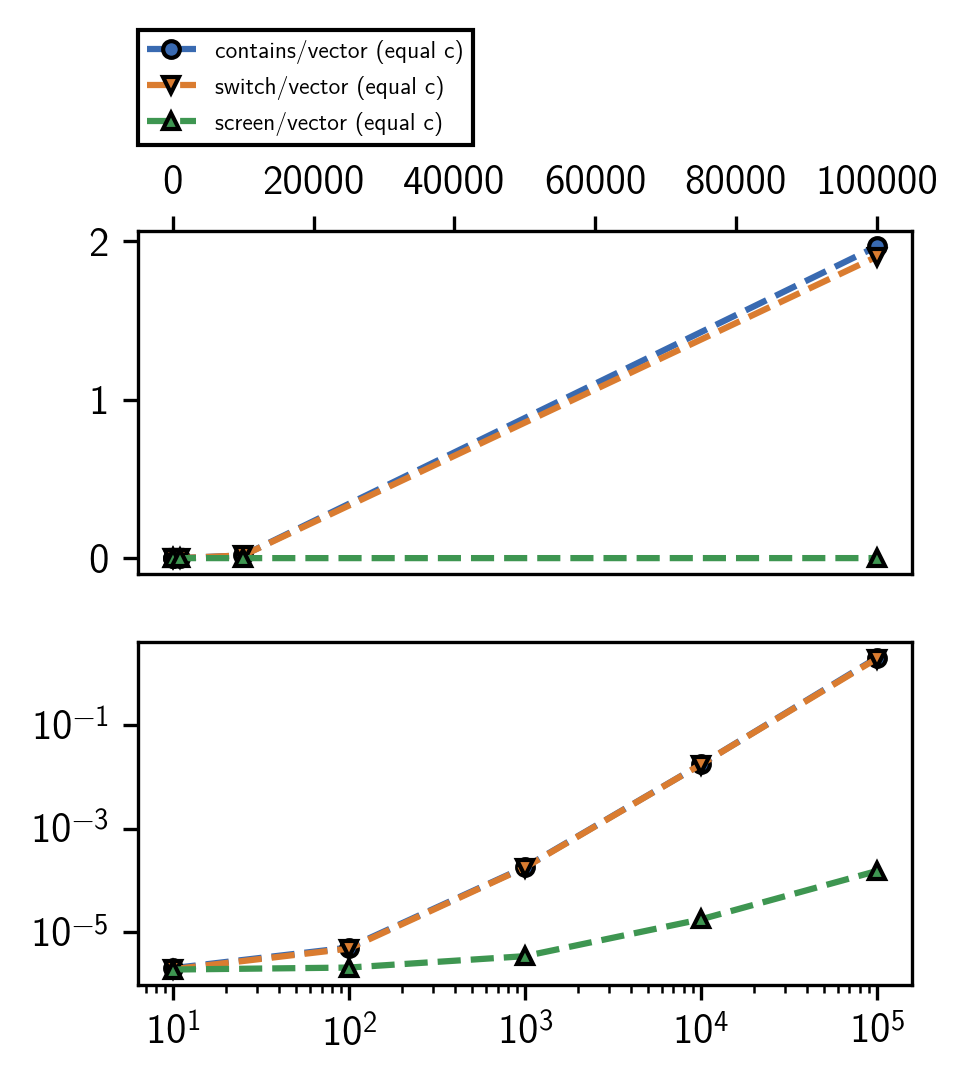

In [33]:
fig, (normal_ax, log_ax) = plt.subplots(2, 1, figsize=(3.33, 3.33))

run_name_list = [
    ('equal_c_run_a_a', 'contains/vector (equal c)'),
    ('equal_c_run_b_a', 'switch/vector (equal c)'),
    ('equal_c_run_c_a', 'screen/vector (equal c)'),
]
markers = iter(["o", "v", "^", "s", "p", "P", "*", "h", "d", "H", "D", ">", "8"])

for name, label in run_name_list:
    marker = next(markers)
    
    helper.plot_timings(
        RUN_TIMINGS_MAP[name],
        ax=normal_ax,
        id_to_x=lambda x: int(x),
        sort_ids=True,
        set_ax_props=False,
        plot_props={
            "label": label,
            "marker": marker,
            "markersize": 4
        }
    )
    
    line = normal_ax.lines[-1]
    log_line, = log_ax.plot(*line.get_xydata().T)
    saved_transform = log_line.get_transform()
    saved_clipbox = log_line.clipbox
    log_line.update_from(line)
    log_line.set_transform(saved_transform)
    log_line.clipbox = saved_clipbox
    
normal_ax.xaxis.tick_top()

normal_ax.set(**{
    "xlabel": None,
    "xlabel": None
})

log_ax.set(**{
    "xlabel": None,
    "xlabel": None,
    "xscale": "log",
    "yscale": "log",
})

legend = normal_ax.legend(
    fancybox=False,
    framealpha=1,
    edgecolor="k",
    fontsize="xx-small",
    loc=(0, 1.25)
    )

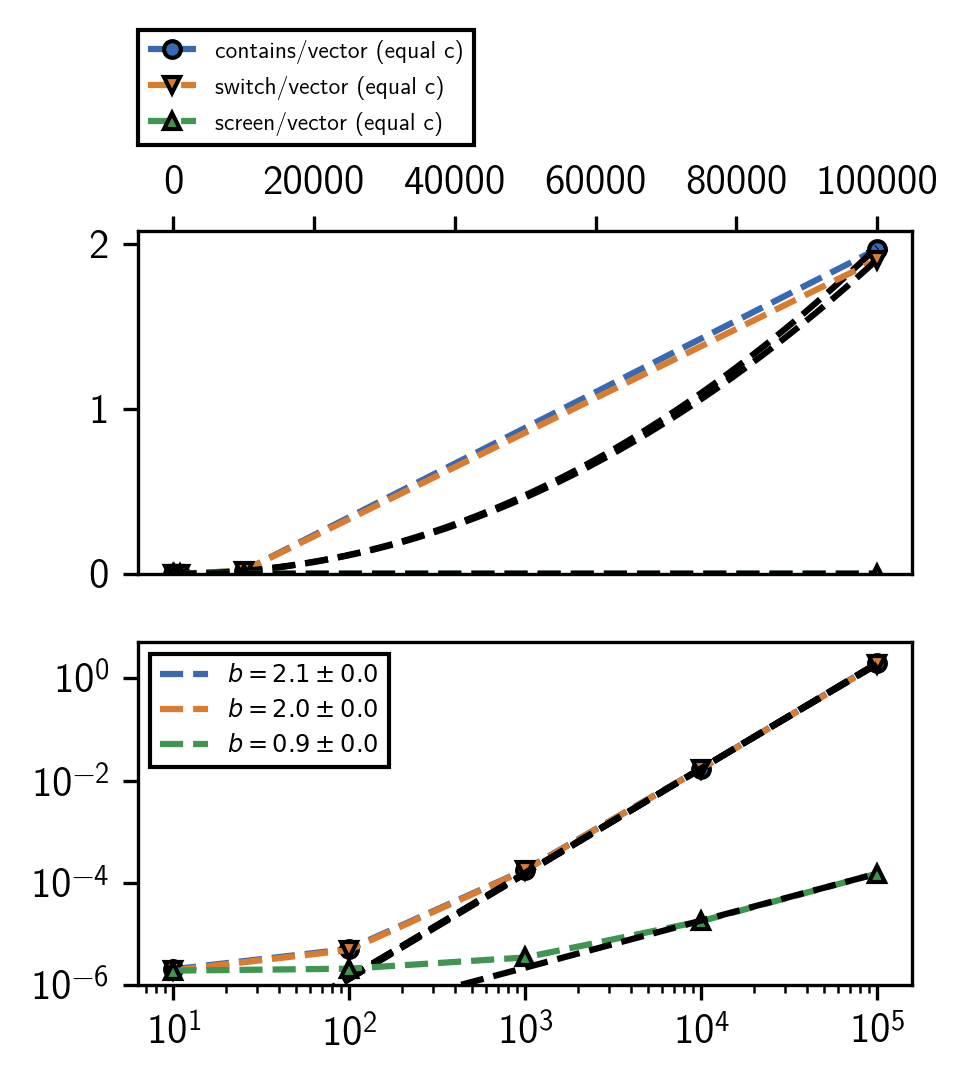

In [103]:
run_name_list = [
    ('equal_c_run_a_a', 'contains/vector (equal c)'),
    ('equal_c_run_b_a', 'switch/vector (equal c)'),
    ('equal_c_run_c_a', 'screen/vector (equal c)'),
]

def evaluate_timings(RUN_TIMINGS_MAP, RUN_SCALING_MAP, run_name_list):
    fig, (normal_ax, log_ax) = plt.subplots(2, 1, figsize=(3.33, 3.33))

    markers = iter(["o", "v", "^", "s", "p", "P", "*", "h", "d", "H", "D", ">", "8"])

    fit_legend_labels = []
    for name, label in run_name_list:
        marker = next(markers)

        line = helper.plot_timings(
            RUN_TIMINGS_MAP[name],
            ax=normal_ax,
            id_to_x=lambda x: int(x),
            sort_ids=True,
            set_ax_props=False,
            plot_props={
                "label": label,
                "marker": marker,
                "markersize": 4,
                "markeredgewidth": 0.75,
            }
        )
        (fity, b), newx = RUN_SCALING_MAP[name]
        fit_line = normal_ax.plot(newx, fity, "k--")
        fit_legend_labels.append(f'$b = {b[0]:.1f} \pm {b[1]:.1f}$')
        fit_legend_lines.append(fit_line)

        for line in [line, fit_line]:
            log_line, = log_ax.plot(*line.get_xydata().T)
            saved_transform = log_line.get_transform()
            saved_clipbox = log_line.clipbox
            log_line.update_from(line)
            log_line.set_transform(saved_transform)
            log_line.clipbox = saved_clipbox

    normal_ax.xaxis.tick_top()

    normal_ax.set(**{
        "xlabel": None,
        "xlabel": None,
        "ylim": (0, None)
    })

    log_ax.set(**{
        "xlabel": None,
        "xlabel": None,
        "xscale": "log",
        "yscale": "log",
        "ylim": (1e-6, None)
    })

    legend = normal_ax.legend(
        fancybox=False,
        framealpha=1,
        edgecolor="k",
        fontsize="xx-small",
        loc=(0, 1.25)
        )
    legend.get_frame().set_linewidth(0.5)
    fitlegend = log_ax.legend(
        fit_legend_lines,
        fit_legend_labels,
        fancybox=False,
        framealpha=1,
        edgecolor="k",
        fontsize="xx-small",
        # loc=(0, 1.25)
        )
    fitlegend.get_frame().set_linewidth(0.5)

In [99]:
legend.get_lines()

In [89]:
RUN_TIMINGS_MAP["mixed_run_a_a"]

{'10': <TimeitResult : 1.75 µs ± 9.23 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)>,
 '100': <TimeitResult : 3.58 µs ± 17.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)>,
 '1000': <TimeitResult : 136 µs ± 20.2 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)>,
 '10000': <TimeitResult : 13 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 '100000': <TimeitResult : 1.46 s ± 513 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)>}

In [90]:
RUN_TIMINGS_MAP["mixed_run_b_a"]

{'10': <TimeitResult : 1.73 µs ± 3.41 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)>,
 '100': <TimeitResult : 3.7 µs ± 5.77 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)>,
 '1000': <TimeitResult : 130 µs ± 162 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)>,
 '10000': <TimeitResult : 13 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 '100000': <TimeitResult : 1.52 s ± 9.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>}